In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize
matplotlib.rcParams["savefig.dpi"] = 100
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["font.size"] = 10
import os
import pickle

## Problem 1

Linear regression for Gaia XP data

In [2]:
# load in the data
tr_file  = "ap17_xpcont_train.pickle"
val_file = "ap17_xpcont_validation.pickle"

with open(tr_file, 'rb') as f1:
    data_tr = pickle.load(f1)

with open(val_file, 'rb') as f2:
    data_val = pickle.load(f2)
    
print("Keys of training set and validation set are:")
print(data_tr.keys(), "\n", data_val.keys())

print("array shape of traing set and validation set are:")
print([data_tr[_].shape for _ in data_tr.keys()], "\n", [data_val[_].shape for _ in data_val.keys()])

Keys of training set and validation set are:
dict_keys(['bp_coef', 'rp_coef', 'labels']) 
 dict_keys(['bp_coef', 'rp_coef', 'labels'])
array shape of traing set and validation set are:
[(4000, 55), (4000, 55), (4000, 2)] 
 [(1000, 55), (1000, 55), (1000, 2)]


In [3]:
bp_tr, rp_tr = data_tr['bp_coef'], data_tr['rp_coef']
teff_tr = data_tr['labels'][:,0]

nstars = len(teff_tr)

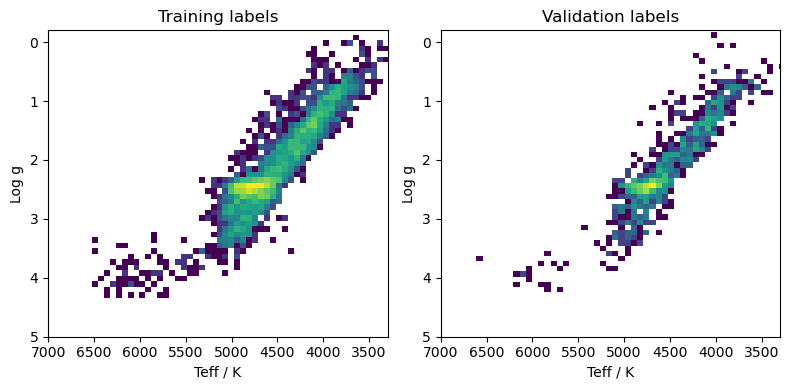

In [4]:
# Data visualization: take training set as an example

# Teff - Log g plot

fig, axs = plt.subplots(1,2,figsize=(8,4))

for i, ax in enumerate(axs.ravel()):
    if i==0:
        ax.hist2d(data_tr['labels'][:,0], data_tr['labels'][:,1],bins=50, norm=LogNorm())
        ax.set_title("Training labels")
    else:
        ax.hist2d(data_val['labels'][:,0], data_val['labels'][:,1],bins=50, norm=LogNorm())
        ax.set_title("Validation labels")
        
    ax.set_xlim([7000, 3300])
    ax.set_ylim([5, -0.2])
    ax.set_xlabel("Teff / K")
    ax.set_ylabel("Log g")
fig.tight_layout()

#### BP and RP coefficients

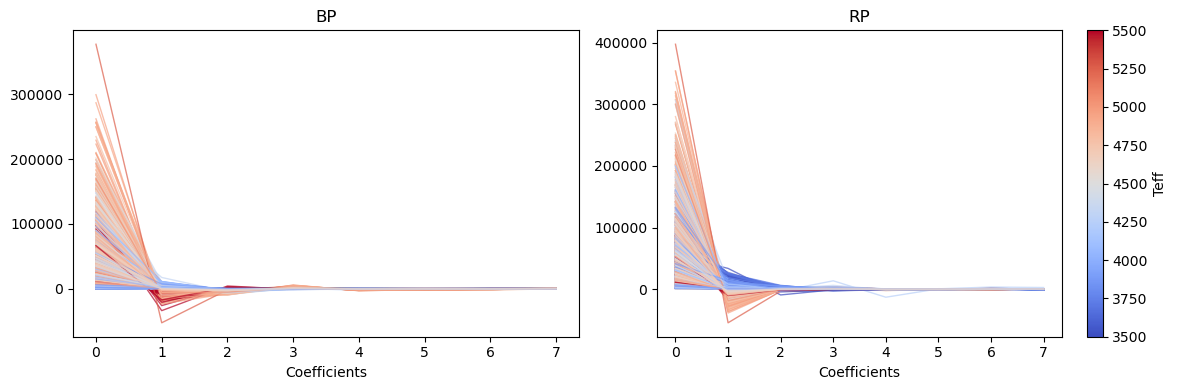

In [5]:
# first eight coefficients color coded by TEFF

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = axs.ravel()

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=3500, vmax=5500)
colors_train_teff = [cmap(norm(_)) for _ in data_tr['labels'][:,0]]

for i, idx in enumerate(range(len(data_tr['labels']))):
    xx = np.arange(8)
    ax1.plot(xx, data_tr['bp_coef'][idx,:8], lw=1, c=colors_train_teff[i], alpha=0.7)
    ax2.plot(xx, data_tr['rp_coef'][idx,:8], lw=1, c=colors_train_teff[i], alpha=0.7)
    
ax1.set_title("BP")
ax2.set_title("RP")

for ax in axs.ravel():
    ax.set_xlabel("index")
    ax.set_xlabel("Coefficients")
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
clb = plt.colorbar(sm, label="Teff")
fig.tight_layout()

#### Dimensionality reduction
Principal component analysis (PCA)

Linear dimensionality reduction using Singular Value Decomposition of the data to project xp coefficients to a lower dimensional space

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(data_tr['bp_coef'])

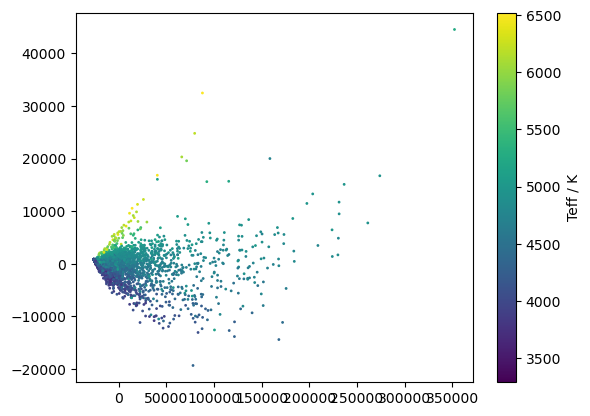

In [7]:
img = plt.scatter(x_pca[:,0], x_pca[:,1], s=1, c=data_tr['labels'][:,0]) 
clb = plt.colorbar(img, label="Teff / K")

** Use linear regression to learn a function that takes as input the BP and RP spectral coefficients and delivers as output the label $T_{\text{eff}}$, the effective temperature of the stars

In [8]:
# start by dividing out each BP and RP component by RP[0], and redefining these as our BPs and RPs for convenience
#   and remember to include 1 as a regressor;
#       the first term in RPs will naturally be 1, and I'll add a 1 to the front of BPs (which will start with one less coefficient to even out)
BPs = np.zeros((nstars, 8))
RPs = np.zeros((nstars, 9))
for idx in range(nstars):
    BPs[idx] = data_tr['bp_coef'][idx,:8] / data_tr['rp_coef'][idx,0]
    RPs[idx] = data_tr['rp_coef'][idx,:9] / data_tr['rp_coef'][idx,0]
BPs = np.insert(BPs, 0, 1., axis=1)

In [9]:
BPs.shape, RPs.shape

((4000, 9), (4000, 9))

So we have $p=18$ features, the spectral coefficients, and for each of $n=4000$ data points, 1 label $y_i = T_{\text{eff}}$.

$\quad\Longrightarrow\quad$ We are in an under-fitted regime ($p < n$)

In [10]:
# feature matrix (nxp)
X_bp = BPs
X_rp = RPs

In [11]:
# labels = effective temperature
Y = data_tr['labels'][:,0]

Then we have (Hogg & Villar):
$$
\hat{\beta} = (X^T X)^{-1} X^T Y
$$

where $\hat{\beta}$ is a $p$-vector of best-fit parameters, and $X^T X$ is invertible. Note that we do not have information about the uncertainty on the data, so this does not involve any data weighting.

The predicted labels $\hat{Y}_\star$ for new data $X_\star$ is
$$
\hat{Y}_\star = X_\star (X^T X)^{-1} X^T Y
$$

I'm going to start by combining the BP and RP coefficients into one $n \times p$ matrix, where $p=18$:

In [12]:
X = np.concatenate((X_bp, X_rp), axis=1)
X.shape

(4000, 18)

In [13]:
def bestfit_pars(X, Y):
    a = X.T @ X
    b = X.T @ Y
    return np.linalg.lstsq(a, b, rcond=0)[0]

In [14]:
def predict_labels(Xstar, X, Y):
    pars = bestfit_pars(X, Y)
    return Xstar @ pars

In [15]:
# test data feature matrix
teff_val = data_val['labels'][:,0]
nstars_val = len(teff_val)
BPs_val = np.zeros((nstars_val, 8))
RPs_val = np.zeros((nstars_val, 9))
for idx in range(nstars_val):
    BPs_val[idx] = data_val['bp_coef'][idx,:8] / data_val['rp_coef'][idx,0]
    RPs_val[idx] = data_val['rp_coef'][idx,:9] / data_val['rp_coef'][idx,0]
BPs_val = np.insert(BPs_val, 0, 1., axis=1)
X_val = np.concatenate((BPs_val, RPs_val), axis=1)
X_val.shape

(1000, 18)

In [16]:
# predict labels for the new set
Ypred = predict_labels(X_val, X, Y)

In [17]:
# residuals
res = Ypred - teff_val

Text(0.5, 1.0, 'Residuals for $T_{eff}$ predictions')

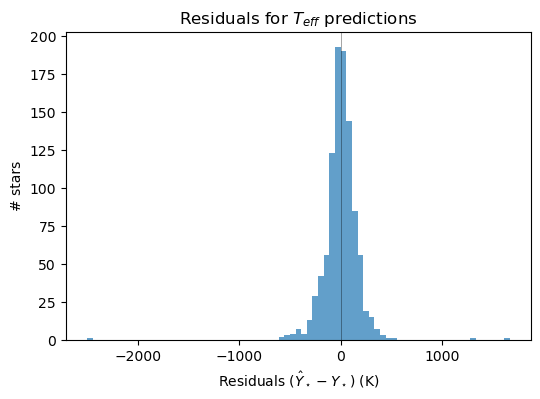

In [18]:
# histogram
fig, ax = plt.subplots(figsize=(6,4))

_, _, _ = ax.hist(res, bins=75, alpha=0.7)
ax.axvline(0, color='k', lw=0.5, alpha=0.5)
ax.set_xlabel('Residuals ($\hat{Y}_\star - Y_\star$) (K)')
ax.set_ylabel('# stars')
ax.set_title('Residuals for $T_{eff}$ predictions')

Text(0.5, 1.0, 'Residuals for $T_{eff}$ predictions')

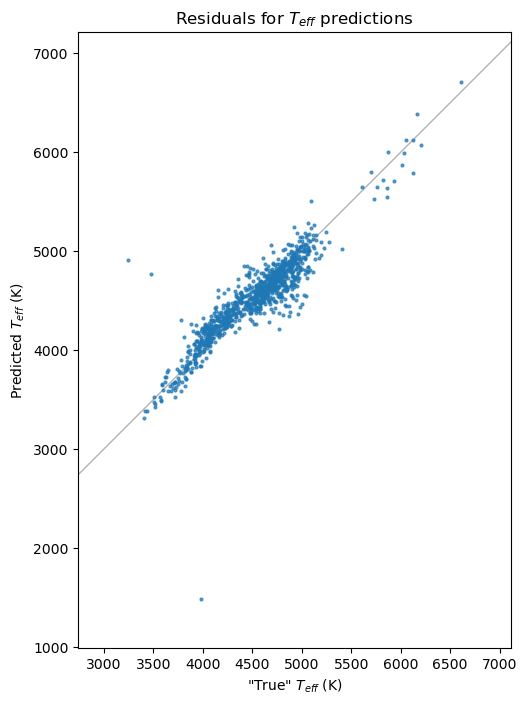

In [19]:
# plotted another (more informative) way: scatter of measured Teff vs predicted
fig, ax = plt.subplots(figsize=(6,8))

x = np.linspace(0, 9000)
ax.plot(x, x, 'k-', alpha=0.3, lw=1)
ax.plot(teff_val, Ypred, ls='None', marker='.', ms=4, alpha=0.7)
ax.set_xlim((min(teff_val)-500), max(teff_val)+500)
ax.set_ylim((min(Ypred)-500, max(Ypred)+500))
ax.set_aspect('equal')
ax.set_xlabel('"True" $T_{eff}$ (K)')
ax.set_ylabel('Predicted $T_{eff}$ (K)')
ax.set_title('Residuals for $T_{eff}$ predictions')

In [20]:
# median absolute deviation
mad = np.median(np.abs(res))
print(f"median absolute deviation = {mad:.2f} K")

# root mean square
rms = np.sqrt(np.mean(res**2))
print(f"root mean square = {rms:.2f} K")

median absolute deviation = 79.83 K
root mean square = 175.77 K


## Problem 2

Make a linear model to predict $T_{\text{eff}}$ using only the RP spectral coefficients.

#### linear combinations of RP coefficients

In [21]:
# we can just use the RP feature matrix from Problem #1, X_rp;
# and the feature matrix for the validation set is
X_val_rp = RPs_val
X_val_rp.shape

(1000, 9)

In [22]:
# predict labels for the new set
Ypred_rp = predict_labels(X_val_rp, X_rp, Y)
# and compute residuals
res_rp = Ypred_rp - teff_val

Text(0.5, 1.0, 'Residuals for $T_{eff}$ predictions (RP coefficients only)')

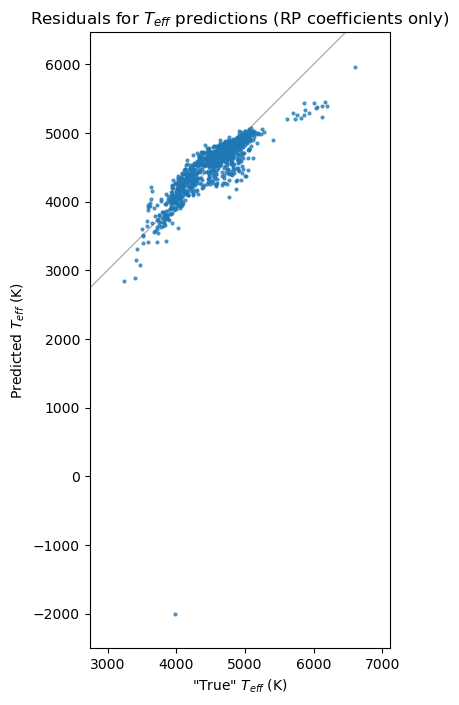

In [23]:
fig, ax = plt.subplots(figsize=(6,8))

x = np.linspace(0, 9000)
ax.plot(x, x, 'k-', alpha=0.3, lw=1)
ax.plot(teff_val, Ypred_rp, ls='None', marker='.', ms=4, alpha=0.7)
ax.set_xlim((min(teff_val)-500), max(teff_val)+500)
ax.set_ylim((min(Ypred_rp)-500, max(Ypred_rp)+500))
ax.set_aspect('equal')
ax.set_xlabel('"True" $T_{eff}$ (K)')
ax.set_ylabel('Predicted $T_{eff}$ (K)')
ax.set_title('Residuals for $T_{eff}$ predictions (RP coefficients only)')

In [24]:
# median absolute deviation
mad = np.median(np.abs(res_rp))
print(f"median absolute deviation = {mad:.2f} K")

# root mean square
rms = np.sqrt(np.mean(res_rp**2))
print(f"root mean square = {rms:.2f} K")

median absolute deviation = 107.62 K
root mean square = 271.38 K


#### linear and quadratic combinations of RP coefficients

In [25]:
# construct our feature matrix
from itertools import combinations_with_replacement as cwr
from scipy.special import comb

# quadratic combinations with replacement
def quad_prods(X):
    n, ncoeffs = X.shape
    quad_vals = np.empty((n, comb(ncoeffs+1, 2, exact=True)))     # comb = binomial coefficient; n multichoose k = n+k+1 choose k
    for i, coeffs in enumerate(X):
        for j, term in enumerate(cwr(coeffs, 2)):
            prod = np.product(term)
            quad_vals[i, j] = prod
    return quad_vals

In [26]:
# combine the linear and quadratic combinations
X_rp_quad = np.concatenate((X_rp, quad_prods(X_rp)), axis=1)
print(X_rp_quad.shape)
X_val_rp_quad = np.concatenate((X_val_rp, quad_prods(X_val_rp)), axis=1)
print(X_val_rp_quad.shape)

(4000, 54)
(1000, 54)


In [27]:
# predict labels for the new set
Ypred_rp_quad = predict_labels(X_val_rp_quad, X_rp_quad, Y)
# residuals
res_rp_quad = Ypred_rp_quad - teff_val

Text(0.5, 1.0, 'Residuals for $T_{eff}$ predictions (RP coefficients only, linear and quadratic combinations)')

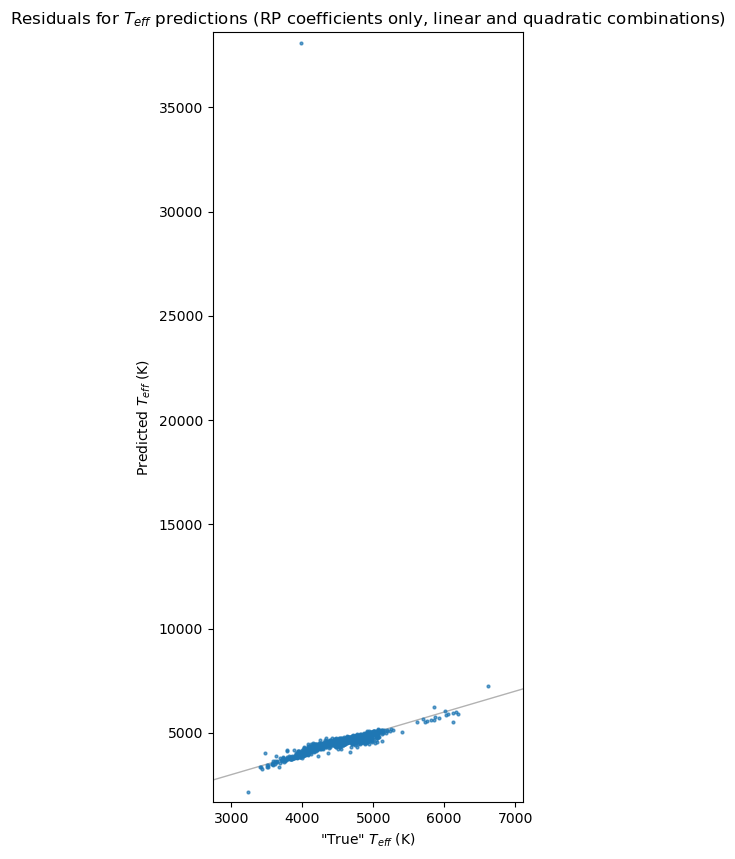

In [28]:
fig, ax = plt.subplots(figsize=(4,10))

x = np.linspace(0, 9000)
ax.plot(x, x, 'k-', alpha=0.3, lw=1)
ax.plot(teff_val, Ypred_rp_quad, ls='None', marker='.', ms=4, alpha=0.7)
ax.set_xlim((min(teff_val)-500), max(teff_val)+500)
ax.set_ylim((min(Ypred_rp_quad)-500, max(Ypred_rp_quad)+500))
# ax.set_aspect('equal')
ax.set_xlabel('"True" $T_{eff}$ (K)')
ax.set_ylabel('Predicted $T_{eff}$ (K)')
ax.set_title('Residuals for $T_{eff}$ predictions (RP coefficients only, linear and quadratic combinations)')

In [29]:
# median absolute deviation
mad = np.median(np.abs(res_rp_quad))
print(f"median absolute deviation = {mad:.2f} K")

# root mean square
rms = np.sqrt(np.mean(res_rp_quad**2))
print(f"root mean square = {rms:.2f} K")

median absolute deviation = 75.78 K
root mean square = 1088.23 K


#### try cubic combinations as well?

In [30]:
# cubic combinations with replacement
def cubic_prods(X):
    n, ncoeffs = X.shape
    cubic_vals = np.empty((n, comb(ncoeffs+2, 3, exact=True)))  # comb = binomial coefficient; n multichoose k = n+k+1 choose k
    for i, coeffs in enumerate(X):
        for j, term in enumerate(cwr(coeffs, 3)):
            prod = np.product(term)
            cubic_vals[i, j] = prod
    return cubic_vals

In [31]:
# combine the linear and quadratic combinations
X_rp_cubic = np.concatenate((X_rp, quad_prods(X_rp), cubic_prods(X_rp)), axis=1)
print(X_rp_cubic.shape)
X_val_rp_cubic = np.concatenate((X_val_rp, quad_prods(X_val_rp), cubic_prods(X_val_rp)), axis=1)
print(X_val_rp_cubic.shape)

(4000, 219)
(1000, 219)


In [32]:
# predict labels for the new set
Ypred_rp_cubic = predict_labels(X_val_rp_cubic, X_rp_cubic, Y)

res_rp_cubic = Ypred_rp_cubic - teff_val

Text(0.5, 1.0, 'Residuals for $T_{eff}$ predictions (RP coefficients only, linear, quadratic, and cubic combinations)')

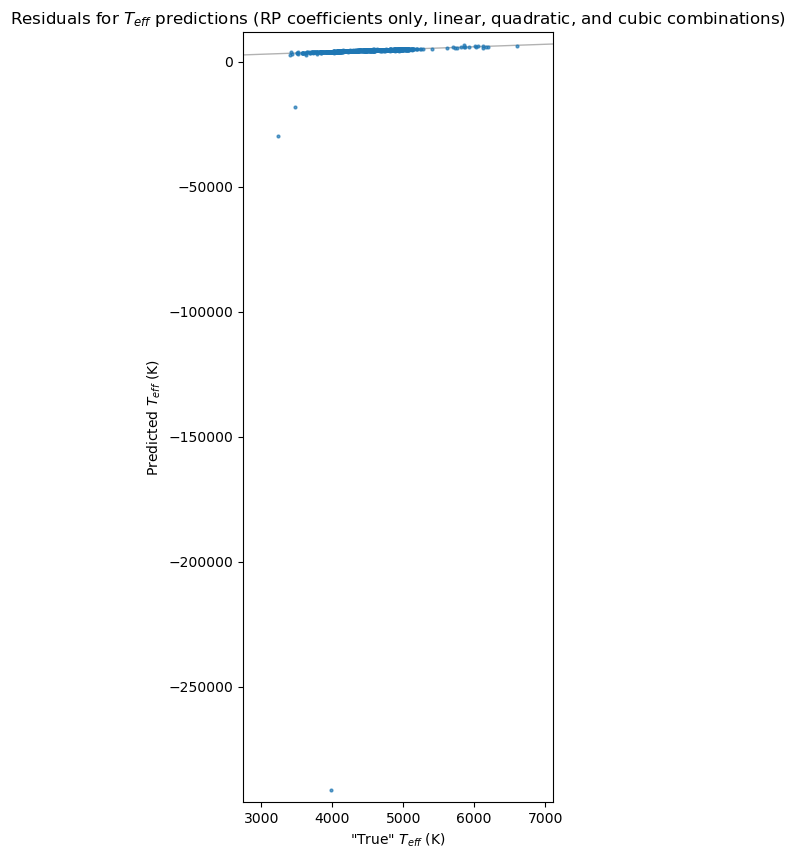

In [33]:
fig, ax = plt.subplots(figsize=(4,10))

x = np.linspace(0, 9000)
ax.plot(x, x, 'k-', alpha=0.3, lw=1)
ax.plot(teff_val, Ypred_rp_cubic, ls='None', marker='.', ms=4, alpha=0.7)
ax.set_xlim((min(teff_val)-500), max(teff_val)+500)
ax.set_ylim((min(Ypred_rp_cubic)-5000, max(Ypred_rp_cubic)+5000))
# ax.set_aspect('equal')
ax.set_xlabel('"True" $T_{eff}$ (K)')
ax.set_ylabel('Predicted $T_{eff}$ (K)')
ax.set_title('Residuals for $T_{eff}$ predictions (RP coefficients only, linear, quadratic, and cubic combinations)')

In [34]:
# median absolute deviation
mad = np.median(np.abs(res_rp_cubic))
print(f"median absolute deviation = {mad:.2f} K")

# root mean square
rms = np.sqrt(np.mean(res_rp_cubic**2))
print(f"root mean square = {rms:.2f} K")

median absolute deviation = 63.09 K
root mean square = 9423.24 K


So the regression models that include quadratic and cubic combinations of RP coefficients, in addition to the linear combinations, mostly fit the measured $T_{\text{eff}}$ values, but with a few significant outliers (the cubic case is especially outrageous). We end up with a nice median absolute deviation but an extremely high RMS. I'm not sure exactly what's going on here, but it's clear that these are not good models in comparison to the linear-only case.

## Problem 3

Fit data set 11 from PS2 using a single Gaussian Process, using the Mattern 3/2 kernel.

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
import pickle as pkl 

In [37]:
# load in the 11th data set from pset 2
with open("pset2_data.pkl", "rb") as handle:
    data = pkl.load(handle).T # check out that pesky little `.T`
time, sigmas, signal = data[0], data[1], data[-1]

In [38]:
# kernel K = Mattern 3/2
# start with a length scale of 30 days
kernel = 1.0 * kernels.Matern(length_scale=30, nu=1.5)

In [39]:
# defining "xdata" and "ydata" for my own sake
xdata = time.reshape(-1,1)      # reshaping the x data to fit the GP function inputs
ydata = signal
xdata.shape, ydata.shape

((1024, 1), (1024,))

In [40]:
# instantiate a GPR class ("alpha" is effectively the diagonal of the noise covariance matrix), and train with this data set
gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigmas, optimizer=None)
gpr.fit(xdata, signal)
gpr.kernel_

1**2 * Matern(length_scale=30, nu=1.5)

In [41]:
# evaluate the GP on a set of test locations: fine grid, slightly wider range than the training data
testgrid = np.arange(-50, 1075, step=0.1)
mean_prediction, std_prediction = gpr.predict(testgrid.reshape(-1,1), return_std=True)

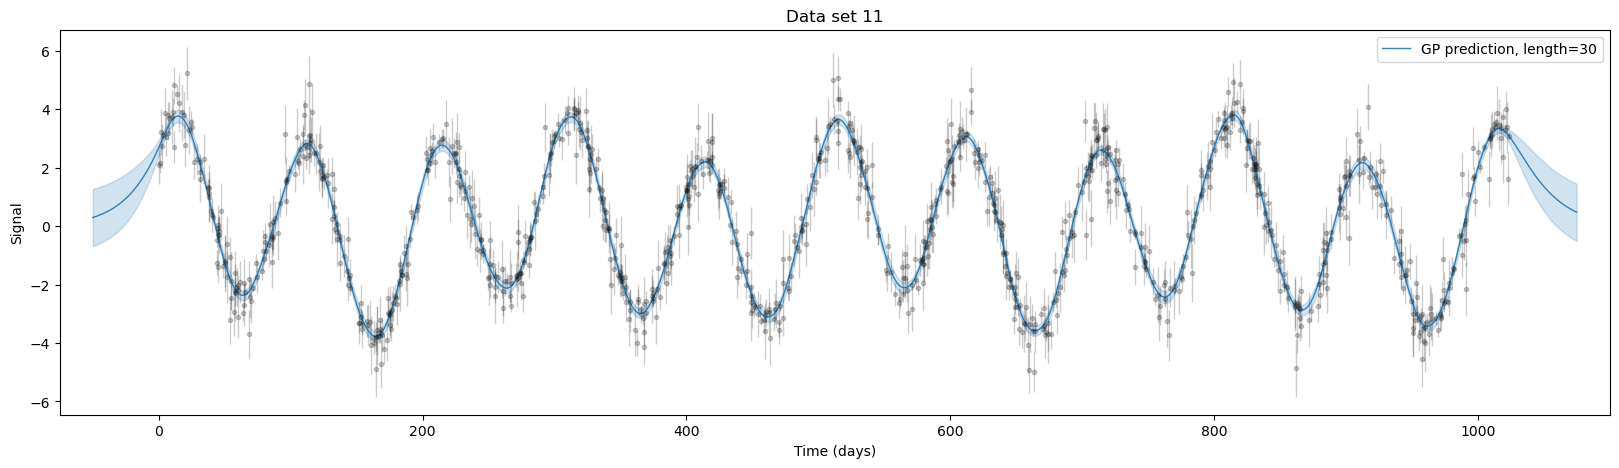

In [50]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.errorbar(xdata, ydata, yerr=sigmas, ls='None', lw=1, color='k', marker='.', alpha=0.2)
ax.plot(testgrid, mean_prediction, lw=1, alpha=0.9, label='GP prediction, length=30')
ax.fill_between(testgrid.T, mean_prediction-std_prediction, mean_prediction+std_prediction, alpha=0.2, color='C0')

ax.set_xlim((-75,1100))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Signal')
ax.set_title(f'Data set 11')
ax.legend()

Plot for two other length scales / values for the kernel width:

In [44]:
# 3 days
kernel3 = 1.0 * kernels.Matern(length_scale=3, nu=1.5)
gpr3 = GaussianProcessRegressor(kernel=kernel3, alpha=sigmas, optimizer=None)
gpr3.fit(xdata, signal)

GaussianProcessRegressor(alpha=array([0.65480801, 0.33871007, 0.7931576 , ..., 0.87951132, 0.9097181 ,
       0.12689071]),
                         kernel=1**2 * Matern(length_scale=3, nu=1.5),
                         optimizer=None)

In [45]:
# 300 days
kernel300 = 1.0 * kernels.Matern(length_scale=300, nu=1.5)
gpr300 = GaussianProcessRegressor(kernel=kernel300, alpha=sigmas, optimizer=None)
gpr300.fit(xdata, signal)

GaussianProcessRegressor(alpha=array([0.65480801, 0.33871007, 0.7931576 , ..., 0.87951132, 0.9097181 ,
       0.12689071]),
                         kernel=1**2 * Matern(length_scale=300, nu=1.5),
                         optimizer=None)

In [47]:
# evaluate the GP on a set of test locations: fine grid, slightly wider range than the training data
testgrid = np.arange(-50, 1075, step=0.1)
mean_pred3, std_pred3 = gpr3.predict(testgrid.reshape(-1,1), return_std=True)
mean_pred300, std_pred300 = gpr300.predict(testgrid.reshape(-1,1), return_std=True)

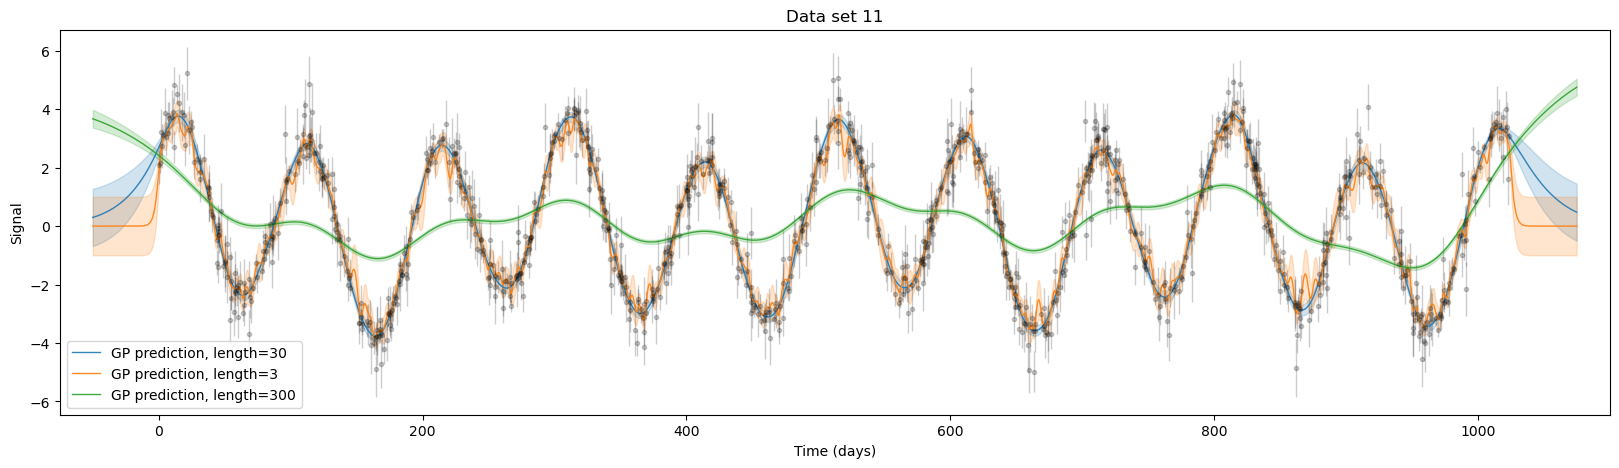

In [49]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.errorbar(xdata, ydata, yerr=sigmas, ls='None', lw=1, color='k', marker='.', alpha=0.2)

ax.plot(testgrid, mean_prediction, lw=1, alpha=0.9, color='C0', label='GP prediction, length=30')
ax.fill_between(testgrid.T, mean_prediction-std_prediction, mean_prediction+std_prediction, alpha=0.2, color='C0')

ax.plot(testgrid, mean_pred3, lw=1, alpha=0.9, color='C1', label='GP prediction, length=3')
ax.fill_between(testgrid.T, mean_pred3-std_pred3, mean_pred3+std_pred3, alpha=0.2, color='C1')

ax.plot(testgrid, mean_pred300, lw=1, alpha=0.9, color='C2', label='GP prediction, length=300')
ax.fill_between(testgrid.T, mean_pred300-std_pred300, mean_pred300+std_pred300, alpha=0.2, color='C2')

ax.set_xlim((-75,1100))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Signal')
ax.set_title(f'Data set 11')
ax.legend()

The kernel width of 30 days is the best fit to the data, compared to 3 and 300 days. We can see that the fit using a kernel width of 3 days has too much freedom of interpolation between the data points, while 300 days results in the opposite situation, where the model cannot "move up and down" enough to adequately match the amplitude of the signal in the data.